# Intan analysis
This notebook will explore the basic pipeline for processing and analyzing neural data recorded using the Intan system.

## Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, re, glob

## Preprocess data

In [2]:
raw_dir = 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928/'

In [10]:
# Placeholders
raw_files = []
ch_id = []

# Find raw files and associated channel IDs
regexp = re.compile(r'amp-A-[0-9]+')
for f in os.listdir(raw_dir):
    if regexp.search(f):
        raw_files.append(f)
        ch_id.append(int(f[6:9]))

# Sort if necessary
ch_id = np.asarray(ch_id)
sort_idx = np.argsort(ch_id)
ch_id = ch_id[sort_idx]
raw_files = [raw_files[i] for i in sort_idx]

In [3]:
raw_files = sorted(glob.glob(raw_dir + 'amp*.dat'))

In [4]:
#for i, f in enumerate(raw_files):
#    raw_files[i] = str([c if c != '\\' else '/' for c in f ])
raw_files

['Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-000.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-001.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-002.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-003.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-004.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-005.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-006.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-007.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-008.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-009.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-010.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-011.dat',
 'Y:/James/data/Ephys/02-04-19/intan/j6z4_d25_190204_162928\\amp-A-012.dat',

In [6]:
# Channels
shank_1 = np.arange(32, dtype=np.int16)
shank_2 = np.arange(64, 128, dtype=np.int16)

raw_files = [raw_files[i] for i in shank_1]
#ch_id = ch_id[shank_1]

In [8]:
## make .mda file for each shank, shank 1 is the left most one on the electrode map picture.
X = []
for i in range(len(raw_files)):    ### for all the channels in your filelist, make the Mx N array
    print('Processing file %d of %d...' % (i+1, len(raw_files)))
    temp = np.fromfile(raw_files[i], dtype=np.int16)
    X.append(temp)
    
X = np.array(X)
print(X.shape)
print('total recording time for this session in mins:  ', len(X[0])/30000/60)

(32, 116875200)
total recording time for this session in mins:   64.93066666666667


In [9]:
cd D:/james/packages/pyms/mlpy

D:\james\packages\pyms\mlpy


In [10]:
from mdaio import writemda16i,writemda32

In [11]:
# save data in your desire directory
writemda16i(X,'D:/james/ms-examples/02-04-19/raw1.mda')
#print(X[:,good_start:good_end].shape)

True

-671446917

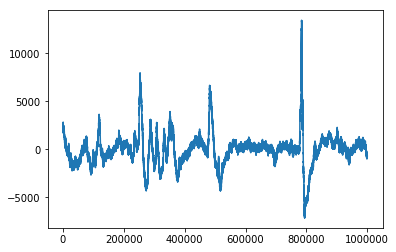

In [37]:
plt.plot(X[0, -1000000:])